# Projeto - Big Data Analytics
## Pontifícia Universidade Católica do Paraná (PUCPR)

* Professor Eduardo Kugler Viegas


### Integrantes da equipe
- Carolina B. Prado
- Rafael C. Sampaio

### Descrição do Projeto

O objetivo do projeto é aplicar as técnicas estudadas em cenários práticos, de modo exploratório, nos datasets disponibilizados ou em outra massa de dados. O projeto esta subdividido em 4 principais frentes, sendo elas:

- **Análise Univariada**: Envolvendo as técnicas de estatistica descritiva e visualização;
- **Análise Multivariada**: Envolvendo as técnicas de inferência estatística e visualização;
- **Visualização**: Tratando técnicas para visualizações de dados
- **Regressão e/ou Classificação**: Envolvendo abordagens de regressão e/ou classificação (quando aplicável) nos dados

### Datasets disponíveis

| # 	| Dataset              	| Link                                                                                                                             	|
|---	|----------------------	|----------------------------------------------------------------------------------------------------------------------------------	|
| 1 	| Acidente             	| https://www.kaggle.com/sobhanmoosavi/us-accidents                                                                                	|
| 2 	| Bovespa              	| https://www.kaggle.com/brunotly/bmfbovespas-time-series-19862019                                                                 	|
| 3 	| COVID                	| https://dados.gov.br/dataset/casos-nacionais                                                                                     	|
| 4 	| DDoS                 	| https://www.kaggle.com/devendra416/ddos-datasets?                                                                                	|
| 5 	| Enem                 	| https://www.kaggle.com/gbonesso/enem-2016                                                                                        	|
| 6 	| Flight               	| https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018                                               	|
| 7 	| Operacoes Comerciais 	| https://www.kaggle.com/unitednations/global-commodity-trade-statistics                                                           	|
| 8 	| Sensor Veicular      	| https://www.kaggle.com/jefmenegazzo/passive-vehicular-sensors-dataset-pvs-1                                                      	|
| 9 	| Tempo                	| https://www.kaggle.com/saraivaufc/automatic-weather-stations-brazil?select=automatic_weather_stations_inmet_brazil_2000_2019.csv 	|


# Importe todas as bibliotecas necessárias

In [ ]:
# pyspark, matplotlib, seaborn, ...
from pyspark.sql.functions import col, avg, stddev, expr, percentile_approx
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import numpy as np

# Iniciar sessão Spark e Carregar dataframe
Abaixo, carregue os seus dados usando o *pyspark sql*.

In [ ]:
#instala pyspark no google colab
!pip install pyspark==3.3.1

In [ ]:
# abre sessão no spark sql
from pyspark.sql import SparkSession

sc = SparkSession \
    .builder \
    .master('local[*]') \
    .getOrCreate()

In [ ]:
#Efetua download da base Tempo
#!gdown 1LYTL1xknqjjFYGLA8cWb9YDS7Nkcd2uI

Base muito grande e demorada, entramos no site indicado e demos download manual e tiramos o ano de 2004 da base, alem de alguns dados que pareciam errados (linhas inteiras de -999 como todos os dados - todos esses casos foram deletados)

In [ ]:
# https://www.kaggle.com/datasets/saraivaufc/automatic-weather-stations-brazil?resource=download
df=sc.read\
    .option('delimiter',',')\
    .option('header','true')\
    .option('inferschema','true')\
    .csv('file:////content/base.csv')

In [ ]:
df.printSchema()

root
 |-- ESTACAO: string (nullable = true)
 |-- DATA (YYYY-MM-DD): string (nullable = true)
 |-- HORA (UTC): integer (nullable = true)
 |-- PRECIPITACAO TOTAL HORARIO (mm): double (nullable = true)
 |-- PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB): double (nullable = true)
 |-- PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB): double (nullable = true)
 |-- PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB): double (nullable = true)
 |-- RADIACAO GLOBAL (W/m2): integer (nullable = true)
 |-- TEMPERATURA DO AR - BULBO SECO HORARIA (C): double (nullable = true)
 |-- TEMPERATURA DO PONTO DE ORVALHO (C): double (nullable = true)
 |-- TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C): double (nullable = true)
 |-- TEMPERATURA MINIMA NA HORA ANT. (AUT) (C): double (nullable = true)
 |-- TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C): double (nullable = true)
 |-- TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C): double (nullable = true)
 |-- UMIDADE REL. MAX. NA HORA ANT. (AUT) (%): integer (nu

In [ ]:
df.select("ESTACAO").distinct().show(10) # descobrimos que estacao nao tem a ver com a estacao do tempo,
#e sim estacao de localidade. baixamos a base que decodifica esses valores para obtermos a regiao.

+-------+
|ESTACAO|
+-------+
|   A802|
|   A003|
|   A308|
|   A305|
|   A410|
|   A906|
|   A406|
|   A804|
|   A604|
|   A903|
+-------+
only showing top 10 rows



In [ ]:
codificacao=sc.read\
    .option('delimiter',';')\
    .option('header','true')\
    .option('inferschema','true')\
    .csv('file:////content/codificacao.csv')

In [ ]:
df_unido = df.join(codificacao, df["ESTACAO"] == codificacao["CODIGO"], "inner")
df_unido.show(10)

+-------+-----------------+----------+-------------------------------+----------------------------------------------------+-----------------------------------------------+------------------------------------------------+----------------------+------------------------------------------+-----------------------------------+-----------------------------------------+-----------------------------------------+-----------------------------------------------+-----------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------+--------------------------+-------------------------+------------------------------+------+---+--------+------+------------+------------+--------+
|ESTACAO|DATA (YYYY-MM-DD)|HORA (UTC)|PRECIPITACAO TOTAL HORARIO (mm)|PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB)|PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)|PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)|RADIACAO GLOBA

# Análise univariada

Nesta seção você deverá apresentar uma análise univariada de dados que analise **ao menos 10 variáveis**.

O objetivo é apresentar o comportamento das variáveis, principalmente no que tange sua distribuição.
Para cada uma das 10 variáveis apresentadas, apresente, com a devida visualização, ao menos:
* Média
* Mediana
* Desvio padrão
* Percentis
* Histogramas

**1-PRECIPITACAO TOTAL HORARIO (mm)**



Resumo da analise: caclular media, mediana e maximo da precipitacao, percentis, tracar histograma para analisar a distribuicao por frequencia da precipitacao no local

In [ ]:
df.filter(col("PRECIPITACAO TOTAL HORARIO (mm)") <= 0).count()

910571

In [ ]:
df.count()

971469

Foi necessario limpar os dados: retirar os valores negativos

In [ ]:
# PRECIPITACAO TOTAL HORARIO (mm)
semzeros = df.filter(col("PRECIPITACAO TOTAL HORARIO (mm)") >= 0)

precipitacao = semzeros.select(
    F.avg(F.col("PRECIPITACAO TOTAL HORARIO (mm)")).alias("Média"),
    F.expr("percentile_approx(`PRECIPITACAO TOTAL HORARIO (mm)`, 0.5)").alias("Mediana"),
    F.stddev(F.col("PRECIPITACAO TOTAL HORARIO (mm)")).alias("Desvio Padrão"),
    F.expr("percentile_approx(`PRECIPITACAO TOTAL HORARIO (mm)`, array(0.25, 0.5, 0.75))").alias("Percentis")
)
precipitacao.show()

+-------------------+-------+------------------+---------------+
|              Média|Mediana|     Desvio Padrão|      Percentis|
+-------------------+-------+------------------+---------------+
|0.17424646908304392|    0.0|1.3682544450764416|[0.0, 0.0, 0.0]|
+-------------------+-------+------------------+---------------+



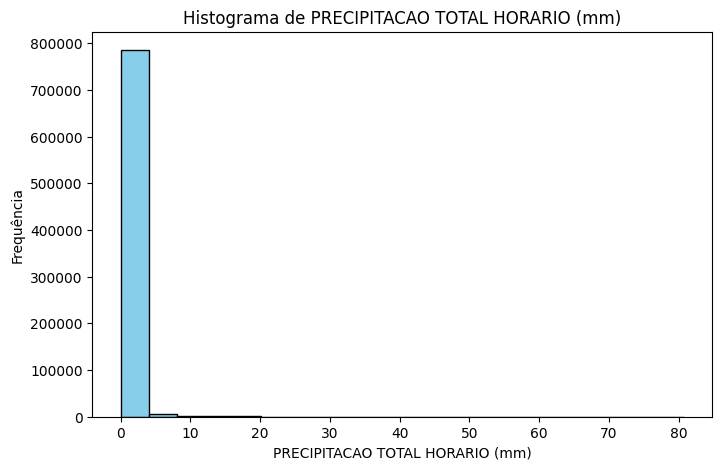

In [ ]:
precipitacao_data = semzeros.select("PRECIPITACAO TOTAL HORARIO (mm)").dropna().rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(8, 5))
plt.hist(precipitacao_data, bins=20, color='skyblue', edgecolor='black')
plt.title("Histograma de PRECIPITACAO TOTAL HORARIO (mm)")
plt.xlabel("PRECIPITACAO TOTAL HORARIO (mm)")
plt.ylabel("Frequência")
plt.show()

Conclusao: chove muito pouco nos dados analisados

In [ ]:
## FUNCAO PARA ANALISE RAPIDA PARA HISTOGRAMA, MEDIA E MEDIANA (facilitar a analise)
def analise_rapida(df, coluna):
    dados = df.select(
        F.avg(F.col(coluna)).alias("Média"),
        F.expr(f"percentile_approx(`{coluna}`, 0.5)").alias("Mediana"),
        F.stddev(F.col(coluna)).alias("Desvio Padrão"),
        F.expr(f"percentile_approx(`{coluna}`, array(0.25, 0.5, 0.75))").alias("Percentis")
    )
    dados.show()

    data = df.select(coluna).dropna().rdd.flatMap(lambda x: x).collect()

    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histograma de {coluna}")
    plt.xlabel(coluna)
    plt.ylabel("Frequência")
    plt.show()

**2- PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB)**


Resumo da analise: caclular dados gerais. Analisar a variavel de modo geral

+-----------------+-------+-----------------+--------------------+
|            Média|Mediana|    Desvio Padrão|           Percentis|
+-----------------+-------+-----------------+--------------------+
|958.5757476520602|  949.0|48.48869755093551|[929.0, 949.0, 10...|
+-----------------+-------+-----------------+--------------------+



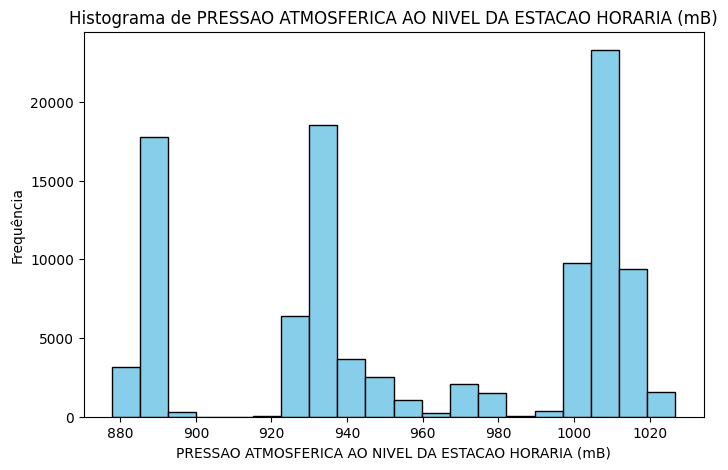

In [ ]:
## pre-analise mostrou muitos dados negativos de pressao, tb. por isso foi filtrado:
semnegativos = df.filter(col("PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB)") >= 0)
analise_rapida(semnegativos, "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB)")

A media de pressao dos dados eh 967.8. Mas a faixa de pressao com maior frequencia eh na faixa de 1000mB - 1025mB

**3- TEMPERATURA DO AR - BULBO SECO HORARIA (C)**

Analise geral dos dados - calcular dados gerais e observar sua frequencia na base

In [ ]:
df.filter(col("TEMPERATURA DO AR - BULBO SECO HORARIA (C)") < 0).show(10)

+-------+-----------------+----------+-------------------------------+----------------------------------------------------+-----------------------------------------------+------------------------------------------------+----------------------+------------------------------------------+-----------------------------------+-----------------------------------------+-----------------------------------------+-----------------------------------------------+-----------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------+--------------------------+-------------------------+------------------------------+
|ESTACAO|DATA (YYYY-MM-DD)|HORA (UTC)|PRECIPITACAO TOTAL HORARIO (mm)|PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB)|PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)|PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)|RADIACAO GLOBAL (W/m2)|TEMPERATURA DO AR - BULBO SECO HORARIA (C)|TEMPERATUR

Muitos -9999 (??????) - Limpeza de dados para so tempereraturas plausiveis (faixa de -50 pra cima)

+------------------+-------+-----------------+------------------+
|             Média|Mediana|    Desvio Padrão|         Percentis|
+------------------+-------+-----------------+------------------+
|23.173473416600274|   23.3|4.661253195149756|[19.9, 23.3, 26.3]|
+------------------+-------+-----------------+------------------+



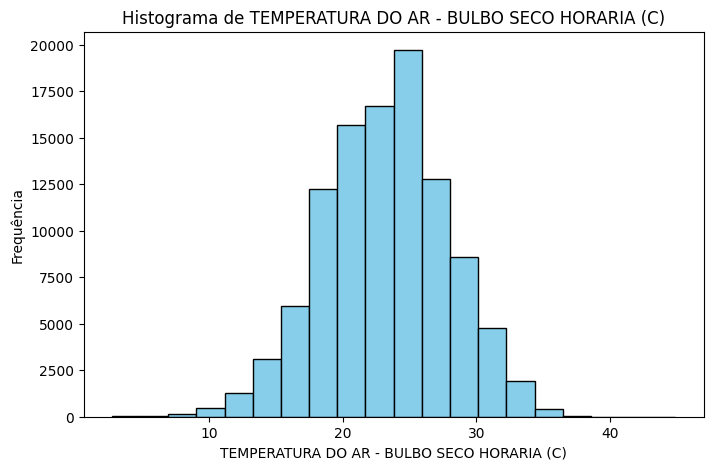

In [ ]:
semnegativos = df.filter(col("TEMPERATURA DO AR - BULBO SECO HORARIA (C)") >= -50)
analise_rapida(semnegativos, "TEMPERATURA DO AR - BULBO SECO HORARIA (C)")

In [ ]:
temperature_bins = [-50, 0, 5, 10, 15, 20, 25, 30, 35, 40, 50]
## intervalos justos
df_temp = df.withColumn(
    "intervalos temp",
    F.lit(None)  )

In [ ]:
for i in range(len(temperature_bins) - 1):
    lower, upper = temperature_bins[i], temperature_bins[i + 1]
    df_temp = df_temp.withColumn(
        "intervalos temp",
        F.when(
            (col("TEMPERATURA DO AR - BULBO SECO HORARIA (C)") >= lower) &
            (col("TEMPERATURA DO AR - BULBO SECO HORARIA (C)") < upper),
            f"{lower} a {upper}°C"
        ).otherwise(col("intervalos temp"))
    )

In [ ]:
faixa_freq = df_temp.filter(F.col("intervalos temp").isNotNull()) \
                    .groupBy("intervalos temp").count() \
                    .orderBy("intervalos temp")

In [ ]:
faixas = [row["intervalos temp"] for row in faixa_freq.collect()]
frequencias = [row["count"] for row in faixa_freq.collect()]

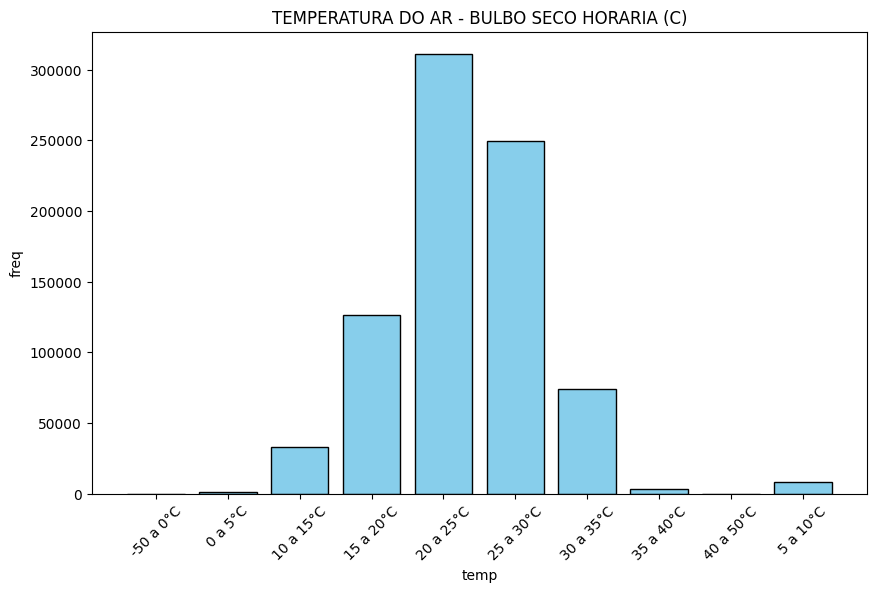

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(faixas, frequencias, color='skyblue', edgecolor='black')
plt.xticks(rotation=45)
plt.xlabel("temp")
plt.ylabel("freq")
plt.title("TEMPERATURA DO AR - BULBO SECO HORARIA (C)")
plt.show()

Conclusao: A base tem mais casos com temperatura entre 20-25 graus

**4- TEMPERATURA DO PONTO DE ORVALHO (C)**

Analise de media, mediana e distribuicao da media dessa coluna com dados que fazem sentido (nao menores que -50graus)

+------------------+-------+-----------------+------------------+
|             Média|Mediana|    Desvio Padrão|         Percentis|
+------------------+-------+-----------------+------------------+
|17.737361605396035|   18.9|4.712518917855936|[15.1, 18.9, 21.4]|
+------------------+-------+-----------------+------------------+



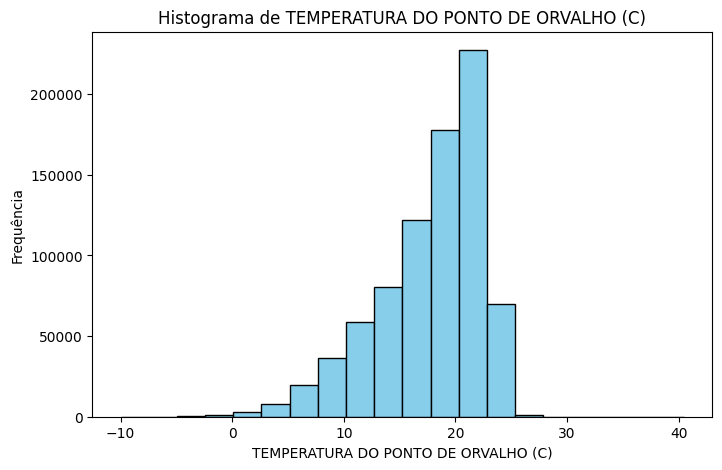

In [ ]:
semmtnegativos = df.filter(col("TEMPERATURA DO PONTO DE ORVALHO (C)") >= -50)
analise_rapida(semmtnegativos, "TEMPERATURA DO PONTO DE ORVALHO (C)")

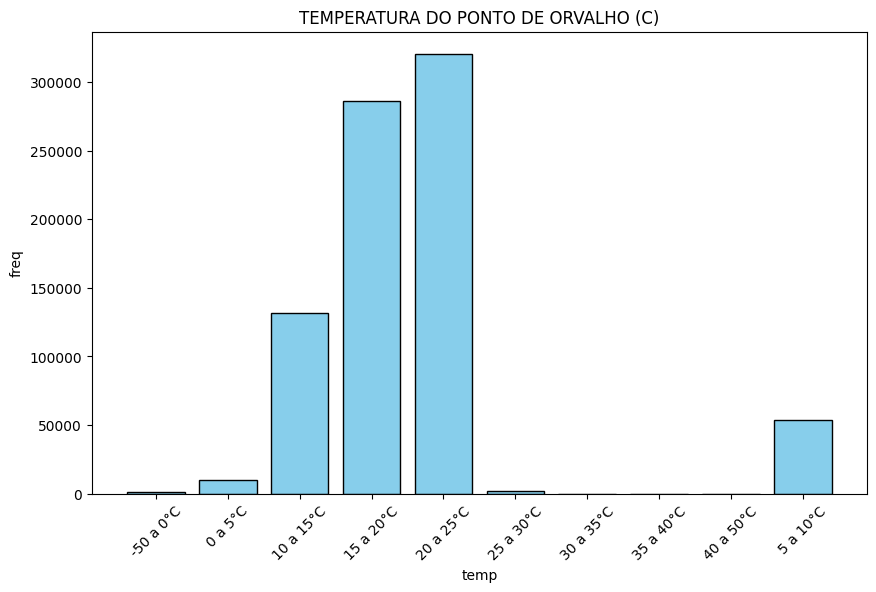

In [ ]:
## redefinimos as variaveis definidas em "TEMPERATURA DO AR - BULBO SECO HORARIA (C)" e so plotamos o grafico aqui para dar menos celulas ;)
plt.figure(figsize=(10, 6))
plt.bar(faixas, frequencias, color='skyblue', edgecolor='black')
plt.xticks(rotation=45)
plt.xlabel("temp")
plt.ylabel("freq")
plt.title("TEMPERATURA DO PONTO DE ORVALHO (C)")
plt.show()

A base tem mais casos com temperatura entre 20-25 graus com uma decaida de 25 a cima.

**5- UMIDADE RELATIVA DO AR HORARIA (%)**

Analise de media, mediana e distribuicao da media dessa coluna

+-----------------+-------+------------------+------------+
|            Média|Mediana|     Desvio Padrão|   Percentis|
+-----------------+-------+------------------+------------+
|72.53722716896253|     76|18.347766236366752|[61, 76, 88]|
+-----------------+-------+------------------+------------+



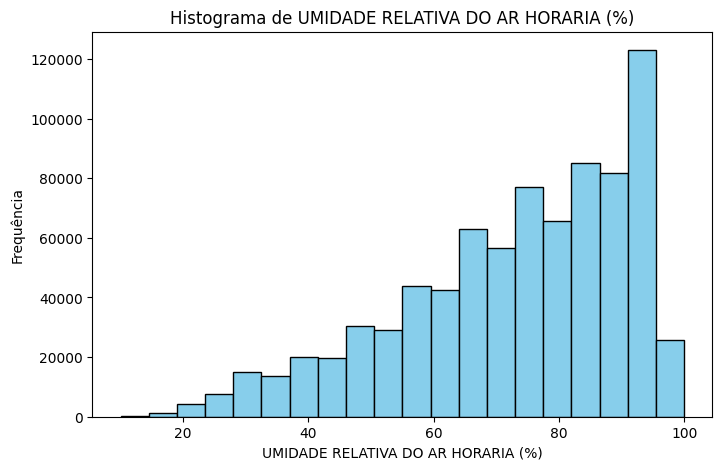

In [ ]:
semnega = df.filter(col("UMIDADE RELATIVA DO AR HORARIA (%)") >= 0)
analise_rapida(semnega, "UMIDADE RELATIVA DO AR HORARIA (%)")

**6-RADIACAO GLOBAL (W/m2)**

Analise de media, mediana e distribuicao da media dessa coluna

+-----------------+-------+-----------------+--------------------+
|            Média|Mediana|    Desvio Padrão|           Percentis|
+-----------------+-------+-----------------+--------------------+
|4065.313863621988| 1479.0|8000.732817483751|[372.0, 1479.0, 2...|
+-----------------+-------+-----------------+--------------------+



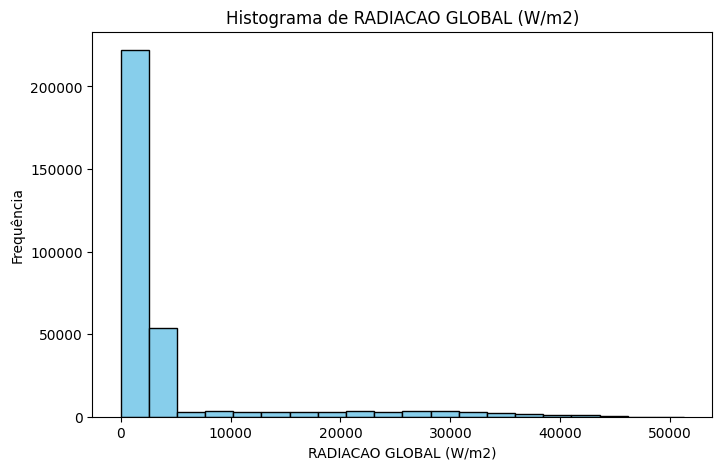

In [ ]:
semnega = df.filter(col("RADIACAO GLOBAL (W/m2)") >= 0)
analise_rapida(semnega, "RADIACAO GLOBAL (W/m2)")


**7-VENTO DIRECAO HORARIA (gr)**


+-----------------+-------+-----------------+--------------------+
|            Média|Mediana|    Desvio Padrão|           Percentis|
+-----------------+-------+-----------------+--------------------+
|149.3304717003857|  124.0|96.32688137232405|[79.0, 124.0, 216.0]|
+-----------------+-------+-----------------+--------------------+



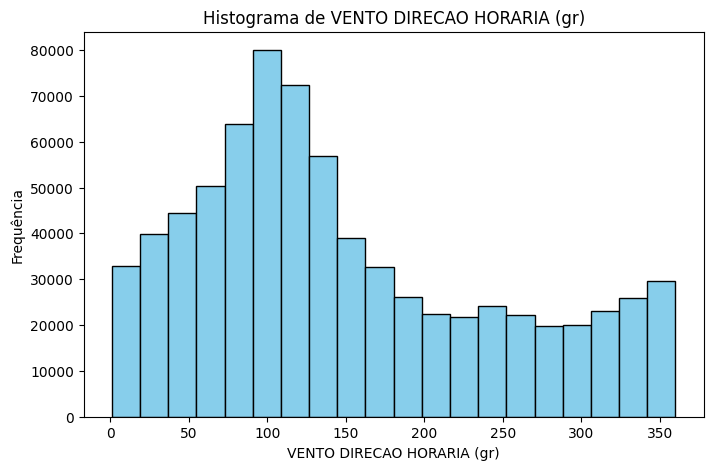

In [ ]:
semvnegativos = df.filter(col("VENTO DIRECAO HORARIA (gr)") >= 0)
analise_rapida(semvnegativos, "VENTO DIRECAO HORARIA (gr)")

**8-VENTO VELOCIDADE HORARIA (m/s)**

+-----------------+-------+------------------+---------------+
|            Média|Mediana|     Desvio Padrão|      Percentis|
+-----------------+-------+------------------+---------------+
|2.337383814043467|    2.1|1.6290285237067714|[1.1, 2.1, 3.3]|
+-----------------+-------+------------------+---------------+



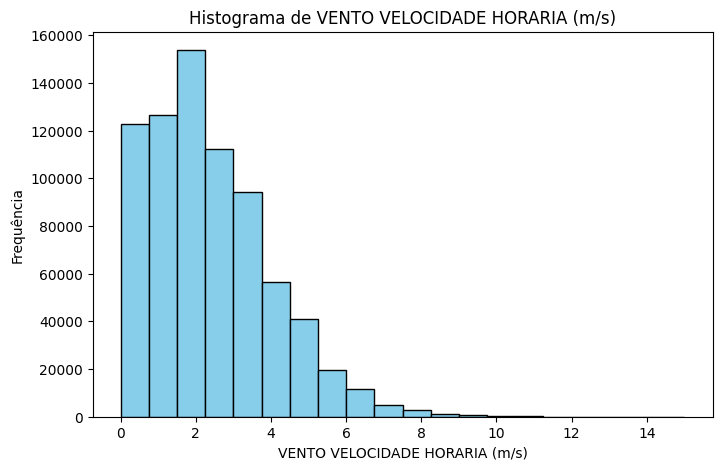

In [ ]:
semvnegativos = df.filter(col("VENTO VELOCIDADE HORARIA (m/s)") >= 0)
analise_rapida(semvnegativos, "VENTO VELOCIDADE HORARIA (m/s)")

**9-TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)**

+------------------+-------+----------------+------------------+
|             Média|Mediana|   Desvio Padrão|         Percentis|
+------------------+-------+----------------+------------------+
|24.229011040551576|   24.4|5.13078822010221|[21.2, 24.4, 27.7]|
+------------------+-------+----------------+------------------+



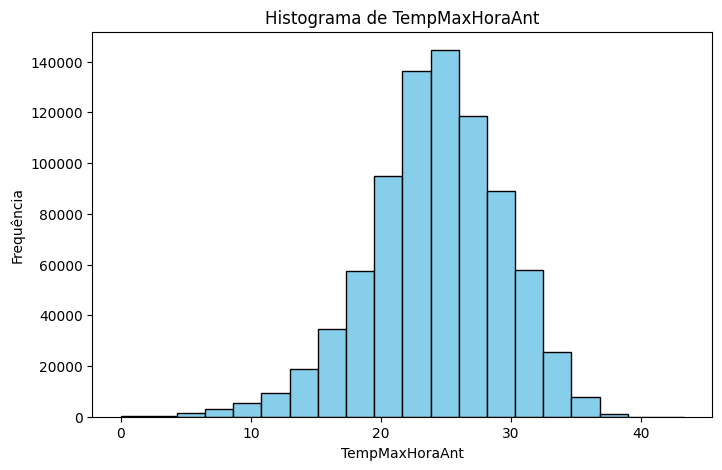

In [ ]:
df = df.withColumnRenamed("TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)", "TempMaxHoraAnt") # tava dando erro com o nome da coluna
semvnegativos = df.filter(col("TempMaxHoraAnt") >= 0)
analise_rapida(semvnegativos, "TempMaxHoraAnt")

**10-TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)**

+-----------------+-------+-----------------+------------------+
|            Média|Mediana|    Desvio Padrão|         Percentis|
+-----------------+-------+-----------------+------------------+
|23.05598911543697|   23.4|4.913939217372138|[20.2, 23.4, 26.3]|
+-----------------+-------+-----------------+------------------+



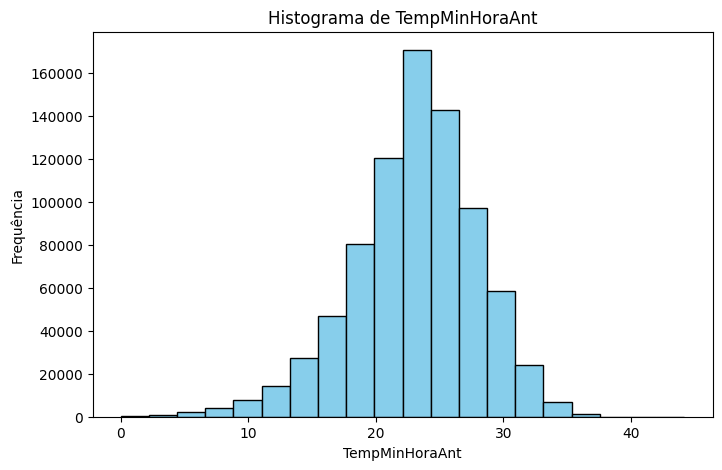

In [ ]:
df = df.withColumnRenamed("TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)", "TempMinHoraAnt") # tava dando erro com o nome da coluna2
semvnegativos = df.filter(col("TempMinHoraAnt") >= 0)
analise_rapida(semvnegativos, "TempMinHoraAnt")

In [ ]:
df.filter(col("PRECIPITACAO TOTAL HORARIO (mm)") <= 0).count()

536635

In [ ]:
df.count()

569570

# Análise multivariada


Nesta seção, você deve gerar ao menos 5 visualizações multivariadas. O objetivo aqui é descobrir relações e/ou correlações entre as variáveis do dataset.
Naturalmente, haverão comportamentos óbvios que serão descobertos, então ao menos **UMA** das visualizações deve apresentar um *insight* não óbvio dos dados.

### Importante

**Todas** as variáveis usadas nesta etapa devem ter sido avaliadas na etapa de análise univariada.

In [ ]:
# remover todos os numeros considerados nao plausiveis na primeira analise.
limite_min = -50
df_filtered = df.filter(
    (F.col("TEMPERATURA DO AR - BULBO SECO HORARIA (C)") >= limite_min) &
    (F.col("TempMaxHoraAnt") >= limite_min) &
    (F.col("TempMinHoraAnt") >= limite_min) &
    (F.col("UMIDADE RELATIVA DO AR HORARIA (%)") >= 0) &
    (F.col("RADIACAO GLOBAL (W/m2)") >= 0) &
    (F.col("VENTO VELOCIDADE HORARIA (m/s)") >= 0) &
    (F.col("PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB)") >= 300)
)
df_unido = df_unido.withColumnRenamed("TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)", "TempMaxHoraAnt") # tava dando erro com o nome da coluna
df_unido = df_unido.withColumnRenamed("TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)", "TempMinHoraAnt") # tava dando erro com o nome da coluna2
df_unido_filt = df_unido.filter(
    (F.col("TEMPERATURA DO AR - BULBO SECO HORARIA (C)") >= limite_min) &
    (F.col("TempMaxHoraAnt") >= limite_min) &
    (F.col("TempMinHoraAnt") >= limite_min) &
    (F.col("UMIDADE RELATIVA DO AR HORARIA (%)") >= 0) &
    (F.col("RADIACAO GLOBAL (W/m2)") >= 0) &
    (F.col("VENTO VELOCIDADE HORARIA (m/s)") >= 0) &
    (F.col("PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB)") >= 300)
)

**1-Relação entre Temperatura do Ar e Umidade Relativa**

In [ ]:
temp_data = df_filtered.select("TEMPERATURA DO AR - BULBO SECO HORARIA (C)", "UMIDADE RELATIVA DO AR HORARIA (%)").dropna().collect()
temp = [row["TEMPERATURA DO AR - BULBO SECO HORARIA (C)"] for row in temp_data]
umidade = [row["UMIDADE RELATIVA DO AR HORARIA (%)"] for row in temp_data]

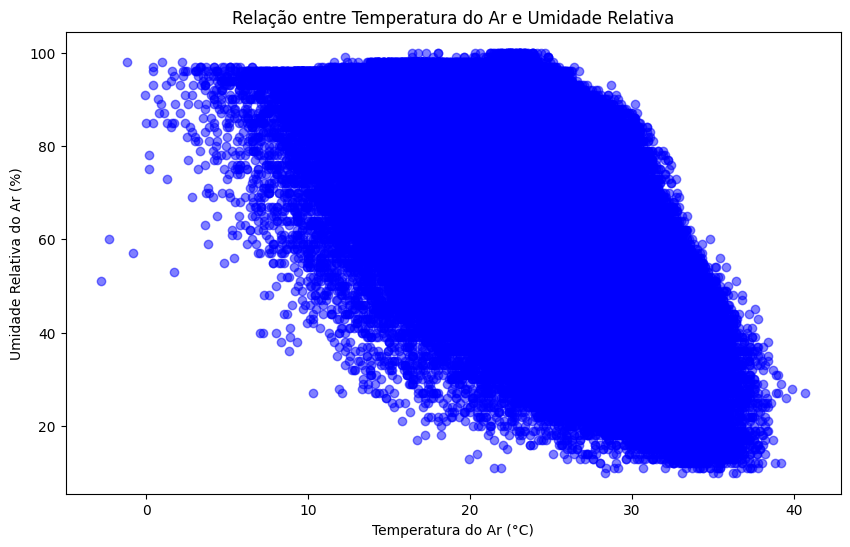

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(temp, umidade, alpha=0.5, color='blue')
plt.title("Relação entre Temperatura do Ar e Umidade Relativa")
plt.xlabel("Temperatura do Ar (°C)")
plt.ylabel("Umidade Relativa do Ar (%)")
plt.show()

**2-Variação de Temperatura Máxima e Mínima ao Longo do Tempo**

In [ ]:
temp_data = df_filtered.select("DATA (YYYY-MM-DD)", "TempMaxHoraAnt", "TempMinHoraAnt").dropna().toPandas() ## hehe pandas eh mais facil de usar
temp_data["DATA (YYYY-MM-DD)"] = pd.to_datetime(temp_data["DATA (YYYY-MM-DD)"])
temp_data = temp_data.sort_values("DATA (YYYY-MM-DD)")
temp_data["TempMax_MediaMovel"] = temp_data["TempMaxHoraAnt"].rolling(window=7).mean()
temp_data["TempMin_MediaMovel"] = temp_data["TempMinHoraAnt"].rolling(window=7).mean()

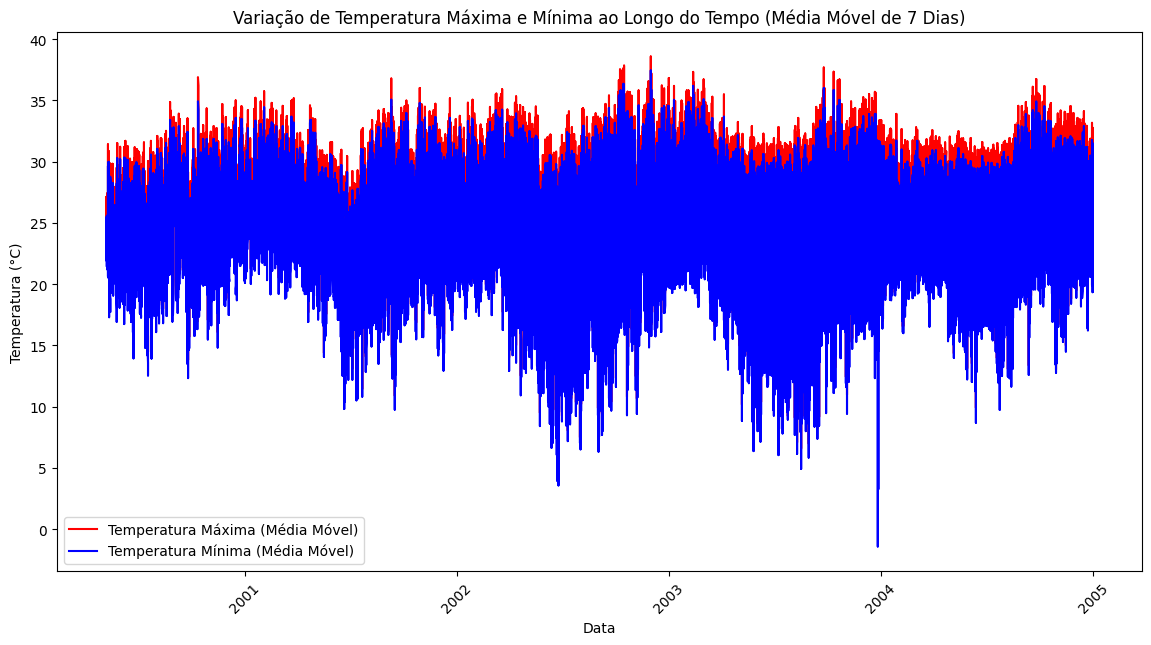

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(temp_data["DATA (YYYY-MM-DD)"], temp_data["TempMax_MediaMovel"], label="Temperatura Máxima (Média Móvel)", color='red')
plt.plot(temp_data["DATA (YYYY-MM-DD)"], temp_data["TempMin_MediaMovel"], label="Temperatura Mínima (Média Móvel)", color='blue')
plt.title("Variação de Temperatura Máxima e Mínima ao Longo do Tempo (Média Móvel de 7 Dias)")
plt.xlabel("Data")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

**4-Correlação entre Variáveis Climáticas**

In [ ]:
climate_data = df_filtered.select("TempMaxHoraAnt", "TempMinHoraAnt", "UMIDADE RELATIVA DO AR HORARIA (%)",
                         "RADIACAO GLOBAL (W/m2)", "TEMPERATURA DO AR - BULBO SECO HORARIA (C)",
                         "VENTO VELOCIDADE HORARIA (m/s)", "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB)") \
                 .dropna().toPandas()

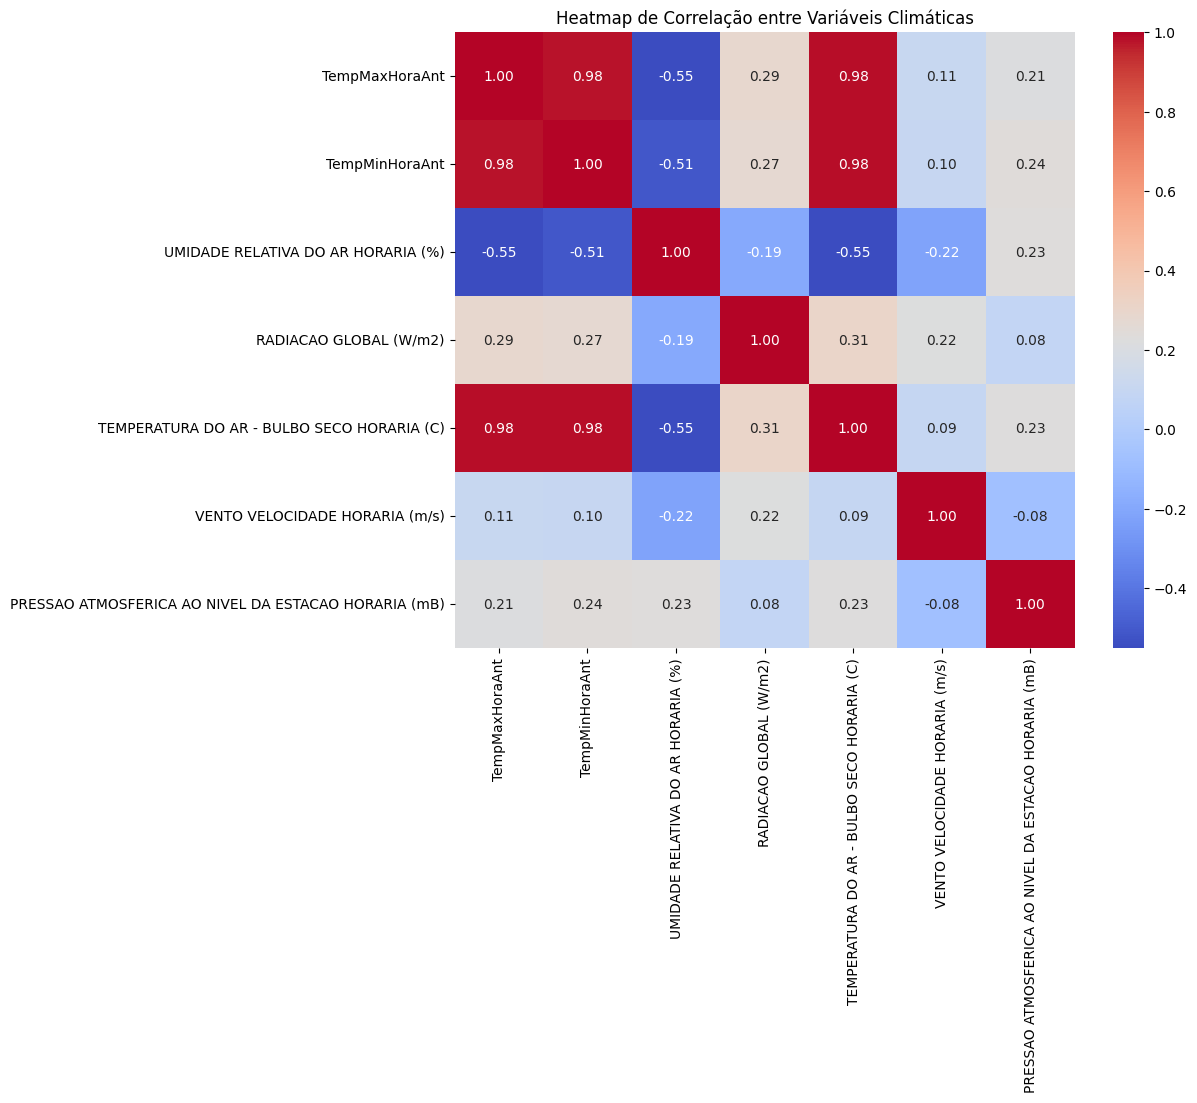

In [ ]:
corr = climate_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap de Correlação entre Variáveis Climáticas")
plt.show()

**5-Variação de Temperatura Máxima e Mínima por regiao**

In [ ]:
media_temp_estacao = df_unido_filt.groupBy("REGIAO") \
                                .agg(F.avg("TempMaxHoraAnt").alias("Media_TempMax"),
                                     F.avg("TempMinHoraAnt").alias("Media_TempMin")) \
                                .orderBy("REGIAO")
media_temp_estacao_pd = media_temp_estacao.toPandas()

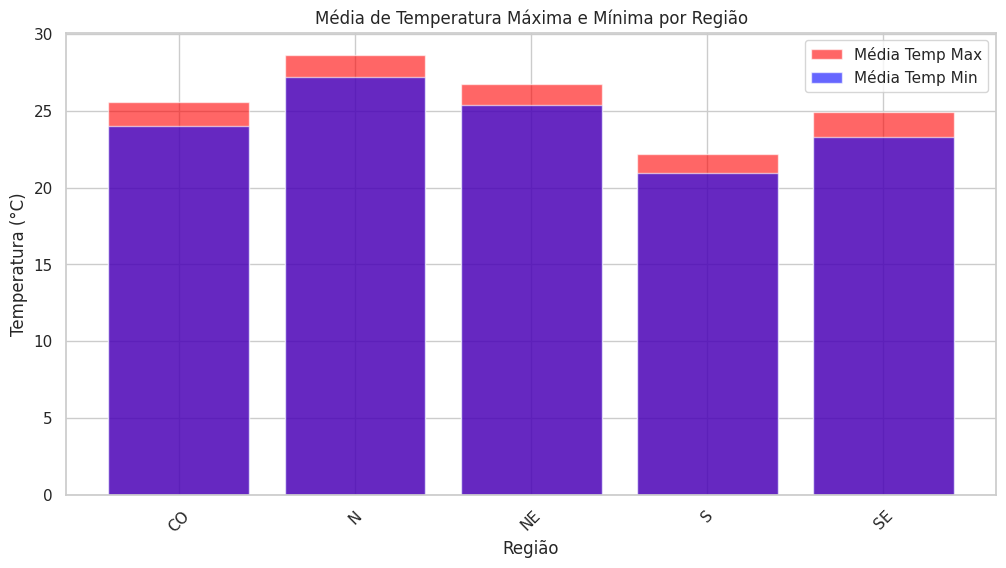

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(media_temp_estacao_pd["REGIAO"], media_temp_estacao_pd["Media_TempMax"], color='red', alpha=0.6, label="Média Temp Max")
plt.bar(media_temp_estacao_pd["REGIAO"], media_temp_estacao_pd["Media_TempMin"], color='blue', alpha=0.6, label="Média Temp Min")
plt.title("Média de Temperatura Máxima e Mínima por Região")
plt.xlabel("Região")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Visualização

Nesta seção, você deve escolher **três visualizações apresentadas anteriormente** e melhorar suas componentes visuais. O objetivo é preparar estas visualizações para uma audiência que não possui *expertise* sobre o dataset analisado.
Desta forma, garanta que o uso de tamanhos, cores, texturas, formas, etc, sejam apropriados e não exista "chart junk".

Uma das visualizações utilizadas deve utilizar alguma técnica de visualização não estudada até o momento

### Dicas
- Utilize outras bibliotecas de visualização disponíveis no python (e.g. seaborn)
- Utilize outros gráficos não estudados até então (e.g. violinplot)

**1-Relação entre Temperatura do Ar e Umidade Relativa**

In [ ]:
temp_data = df_filtered.select("TEMPERATURA DO AR - BULBO SECO HORARIA (C)", "UMIDADE RELATIVA DO AR HORARIA (%)").dropna().toPandas()
sns.set(style="whitegrid")

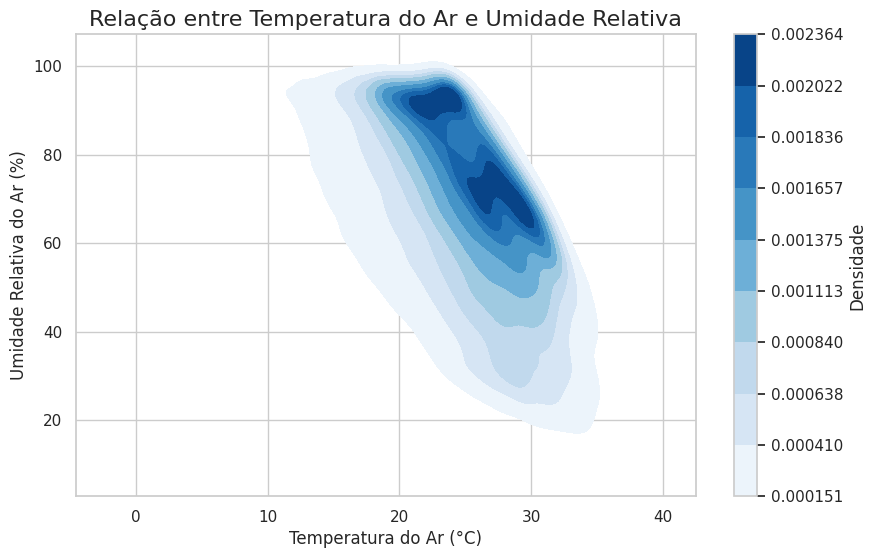

In [ ]:
plt.figure(figsize=(10, 6))
scatter = sns.kdeplot(
    data=temp_data,
    x="TEMPERATURA DO AR - BULBO SECO HORARIA (C)",
    y="UMIDADE RELATIVA DO AR HORARIA (%)",
    cmap="Blues",
    fill=True,
    thresh=0.05
)
plt.title("Relação entre Temperatura do Ar e Umidade Relativa", fontsize=16)
plt.xlabel("Temperatura do Ar (°C)", fontsize=12)
plt.ylabel("Umidade Relativa do Ar (%)", fontsize=12)
plt.colorbar(scatter.collections[0], label="Densidade")
plt.show()

Analisamos uma correlacao aparentemente negativa entre essas duas variaveis.

**2-Variação de Temperatura Máxima e Mínima ao Longo do Tempo**

In [ ]:
temp_data = df_filtered.select("DATA (YYYY-MM-DD)", "TempMaxHoraAnt", "TempMinHoraAnt").dropna().toPandas()
temp_data["DATA (YYYY-MM-DD)"] = pd.to_datetime(temp_data["DATA (YYYY-MM-DD)"])
temp_data = temp_data.sort_values("DATA (YYYY-MM-DD)")
temp_data["TempMax_MediaMovel"] = temp_data["TempMaxHoraAnt"].rolling(window=7).mean()
temp_data["TempMin_MediaMovel"] = temp_data["TempMinHoraAnt"].rolling(window=7).mean()

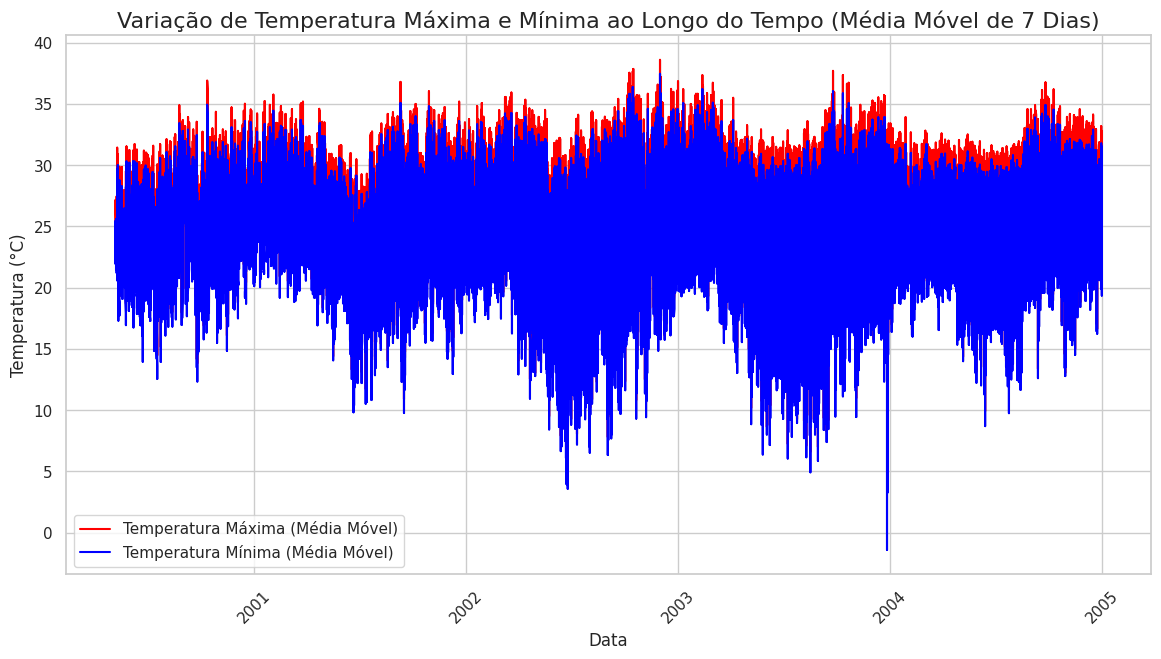

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(temp_data["DATA (YYYY-MM-DD)"], temp_data["TempMax_MediaMovel"], label="Temperatura Máxima (Média Móvel)", color='red')
plt.plot(temp_data["DATA (YYYY-MM-DD)"], temp_data["TempMin_MediaMovel"], label="Temperatura Mínima (Média Móvel)", color='blue')
plt.fill_between(temp_data["DATA (YYYY-MM-DD)"], temp_data["TempMax_MediaMovel"], temp_data["TempMin_MediaMovel"], color='gray', alpha=0.2)
plt.title("Variação de Temperatura Máxima e Mínima ao Longo do Tempo (Média Móvel de 7 Dias)", fontsize=16)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Temperatura (°C)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.show()

Analisamos pelo grafico que a variacao de Temperatura Maxima é bem similar a variação de Temperatura Minima, com obviamente um aumento no maximo.
Além disso, parece que a variação aumenta com o passar dos anos, algo não tão óbvio quando analisamos os dados no geral

**3-Correlação entre Variáveis Climáticas**

In [ ]:
climate_data = df_filtered.select("TempMaxHoraAnt", "TempMinHoraAnt", "UMIDADE RELATIVA DO AR HORARIA (%)",
                                  "RADIACAO GLOBAL (W/m2)", "TEMPERATURA DO AR - BULBO SECO HORARIA (C)",
                                  "VENTO VELOCIDADE HORARIA (m/s)", "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB)").dropna().toPandas()
corr = climate_data.corr()

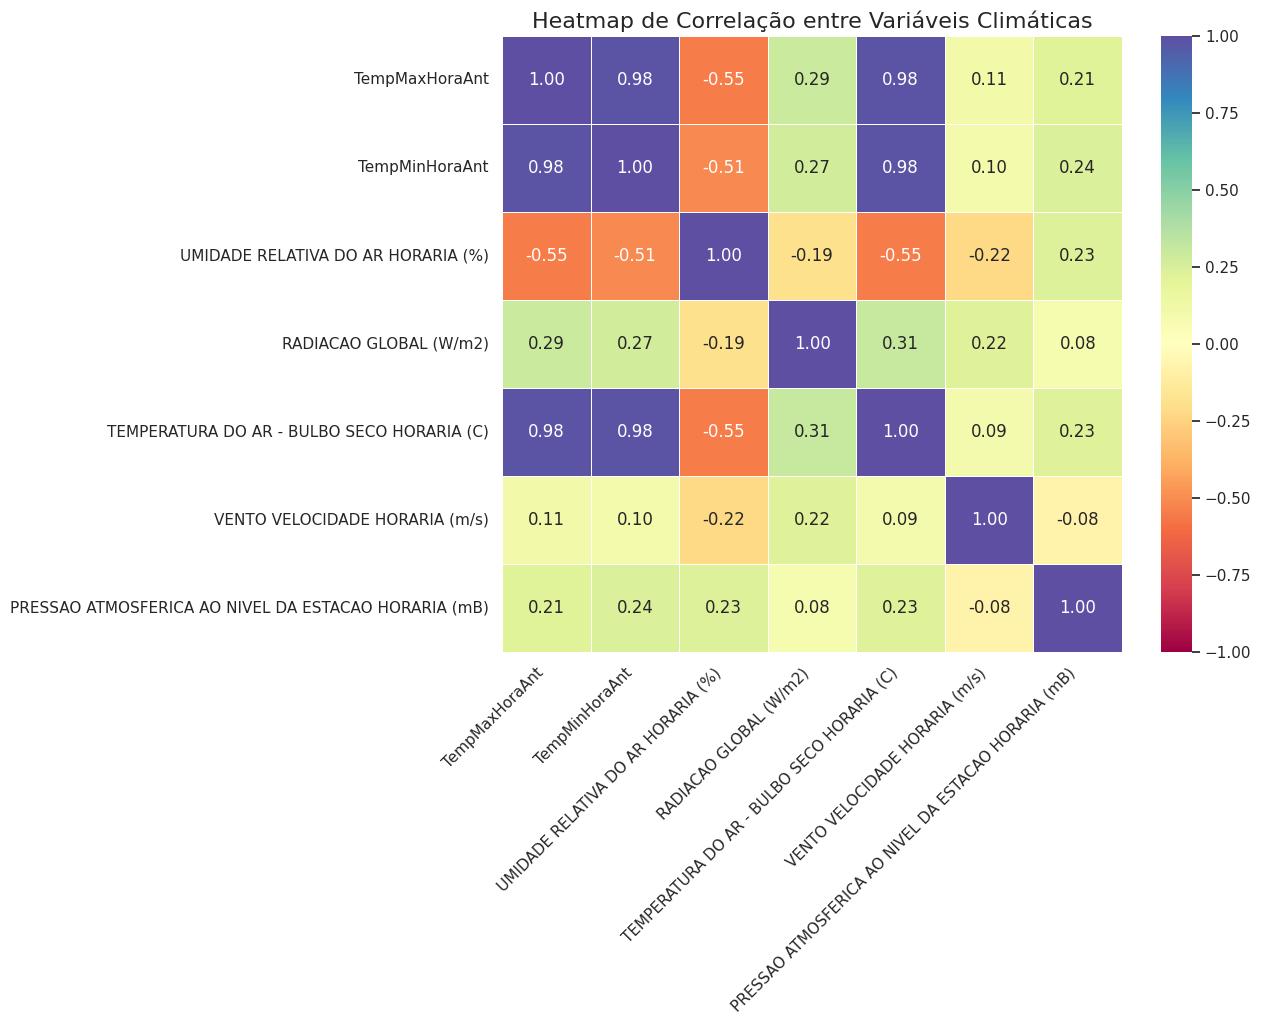

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="Spectral", center=0, vmin=-1, vmax=1, fmt=".2f", linewidths=0.5, linecolor='white')
plt.title("Heatmap de Correlação entre Variáveis Climáticas", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

Juntamos o resultado desta matriz com o conteúdo dado em sala, observamos que os quadrados com cores azuis mostram uma correlação forte entre as variáveis da linha do quadrado em questão. Quadrados com cores alaranjadas e verdes mostram correlação intermediária entre as variáveis, enquanto quadrados com cores mais claras (verde claro e amarelo claro - ou bege) mostram correlação fraca entre as variáveis.

# Regressão e/ou classificação

Nesta seção, você deve aplicar técnicas de regressão e/ou classificação sobre os dados utilizados. Utilize regressão para prever valores numéricos, quando aplicável. Utilize classificação para prever valores categóricos quando aplicável. Note, não são todos datasets que permitem a utilização de técnicas de regressão e/ou classificação, sendo assim discuta com seu professor o objetivo previsto nesta avaliação em seu dataset

**Prever temperaturas mínima e máxima futuras**



A ideia desta regressão é prever temperaturas mínima e máxima futuras para uma região específica (neste caso, a região SUL!) com base em variáveis climáticas dadas pela base de dados.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pyspark.sql import functions as F

In [ ]:
df_region_s = df_unido_filt.filter(F.col("REGIAO") == "S")

In [ ]:
data = df_region_s.select("DATA (YYYY-MM-DD)", "TempMaxHoraAnt", "TempMinHoraAnt",
                          "UMIDADE RELATIVA DO AR HORARIA (%)", "RADIACAO GLOBAL (W/m2)",
                          "TEMPERATURA DO AR - BULBO SECO HORARIA (C)",
                          "VENTO VELOCIDADE HORARIA (m/s)",
                          "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB)").dropna().toPandas()

In [ ]:
data["DATA (YYYY-MM-DD)"] = pd.to_datetime(data["DATA (YYYY-MM-DD)"])
data["Ano"] = data["DATA (YYYY-MM-DD)"].dt.year
data["Mes"] = data["DATA (YYYY-MM-DD)"].dt.month
data["Dia"] = data["DATA (YYYY-MM-DD)"].dt.day

In [ ]:
X = data[["Ano", "Mes", "Dia", "UMIDADE RELATIVA DO AR HORARIA (%)", "RADIACAO GLOBAL (W/m2)",
          "TEMPERATURA DO AR - BULBO SECO HORARIA (C)", "VENTO VELOCIDADE HORARIA (m/s)",
          "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB)"]]
y_max = data["TempMaxHoraAnt"]
y_min = data["TempMinHoraAnt"]

In [ ]:
X_train, X_test, y_max_train, y_max_test = train_test_split(X, y_max, test_size=0.2, random_state=42)
X_train, X_test, y_min_train, y_min_test = train_test_split(X, y_min, test_size=0.2, random_state=42)

In [ ]:
model_max = LinearRegression()
model_min = LinearRegression()

model_max.fit(X_train, y_max_train)
model_min.fit(X_train, y_min_train)

LinearRegression()

In [ ]:
y_max_pred = model_max.predict(X_test)
y_min_pred = model_min.predict(X_test)

In [ ]:
mae_max = mean_absolute_error(y_max_test, y_max_pred)
rmse_max = np.sqrt(mean_squared_error(y_max_test, y_max_pred))

mae_min = mean_absolute_error(y_min_test, y_min_pred)
rmse_min = np.sqrt(mean_squared_error(y_min_test, y_min_pred))

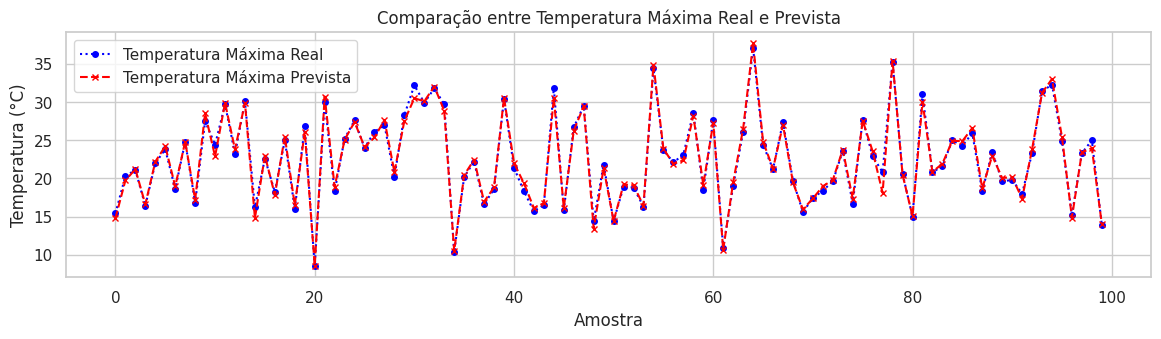

In [ ]:
plt.figure(figsize=(14, 7))
n_samples = 100

plt.subplot(2, 1, 1)
plt.plot(y_max_test[:n_samples].values, label="Temperatura Máxima Real", color='blue', marker='o', markersize=4, linestyle='dotted')
plt.plot(y_max_pred[:n_samples], label="Temperatura Máxima Prevista", color='red', marker='x', markersize=4, linestyle='dashed')
plt.title("Comparação entre Temperatura Máxima Real e Prevista")
plt.xlabel("Amostra")
plt.ylabel("Temperatura (°C)")
plt.legend()

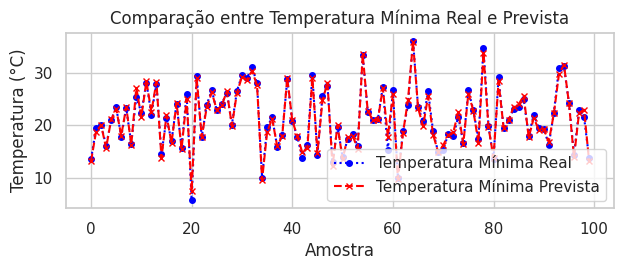

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(y_min_test[:n_samples].values, label="Temperatura Mínima Real", color='blue', marker='o', markersize=4, linestyle='dotted')
plt.plot(y_min_pred[:n_samples], label="Temperatura Mínima Prevista", color='red', marker='x', markersize=4, linestyle='dashed')
plt.title("Comparação entre Temperatura Mínima Real e Prevista")
plt.xlabel("Amostra")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(f"Desempenho do modelo para Temperatura Máxima:")
print(f"MAE (Erro Médio Absoluto): {mae_max}")

print(f"Desempenho do modelo para Temperatura Mínima:")
print(f"MAE (Erro Médio Absoluto): {mae_min}")

Desempenho do modelo para Temperatura Máxima:
MAE (Erro Médio Absoluto): 0.46873386867983186
Desempenho do modelo para Temperatura Mínima:
MAE (Erro Médio Absoluto): 0.5448255224457086


In [ ]:
# adicione seu código aqui